This notebook is part of a presentation I gave for an ML reading group I started at Shopify.

Meant to be viewed as a slideshow.

To view this notebook, run this command:

```bash
jupyter nbconvert notebooks/Gaussian\ Processes.ipynb --to slides --post serve
```

Side note: What would be great is if I could have a `watch` command that listens for changes to the notebook and then updates the web slides automatically. Looks like it would have to be a change [here](https://github.com/jupyter/nbconvert/blob/474fe3c080211b5eefdd6c3e7c313a1ddba2fa9d/nbconvert/postprocessors/serve.py). There's an issue for this here: https://github.com/jupyter/nbconvert/issues/826

In [15]:
import warnings
warnings.filterwarnings('ignore')

In [16]:
import collections

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

tfe = tf.contrib.eager
try:
    tfe.enable_eager_execution()
except ValueError:
    pass

import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
import seaborn as sns

# Overview of Gaussian processes

By Elijah Tai

### What we'll cover

* intuition for Gaussians (univariate, multivariate)
* uncertainty measurement
* distributions over functions

### Univariate Gaussian

A one-dimensional Gaussian is simply described with two parameters: 
* $\mu$ =  mean
* $\sigma$ = standard deviation

$\mathcal{X}$ ~ $\mathcal{N}(\mu, \sigma)$

For fun, let's model the "sweetness" of a Florida navel orange over time. Assume sweetness of Florida's navel oranges in **December** come from a Gaussian with
  * $\mu = 5$ grams / 100 grams of orange
  * $\sigma = 0.25$
  
$sweetness_{december}$ ~ $\mathcal{N}(5, 0.25)$

Let's say you measured the sweetness of 10000 oranges.

[Text(0,0.5,'probability'),
 Text(0.5,0,'sugar content (grams)'),
 Text(0.5,1,'Distribution of Florida orange sweetness in December')]

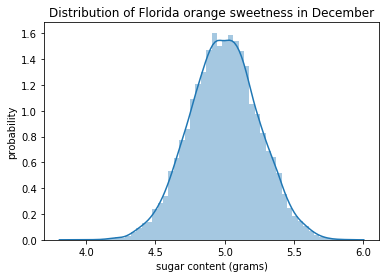

In [17]:
dec_dist = tfd.Normal(loc=5., scale=0.25)

dec_samples = dec_dist.sample(10000).numpy()
ax = sns.distplot(dec_samples)
ax.set(
    xlabel="sugar content (grams)", 
    ylabel="probability",
    title="Distribution of Florida orange sweetness in December"
)

Because we're measuring the sweetness content of Florida oranges **over time**, we're going to go out and measure again in January.

### Multivariate Gaussian

Let's assume **January's** oranges are bit sweeter on average but they fluctuate more, and have:
* $\mu = 10$ grams / 100 grams of orange
* $\sigma = 3$

$sweetness_{january}$ ~ $\mathcal{N}(10, 3)$

[Text(0,0.5,'probability'),
 Text(0.5,0,'sugar content (grams)'),
 Text(0.5,1,'Distribution of Florida orange sweetness in January')]

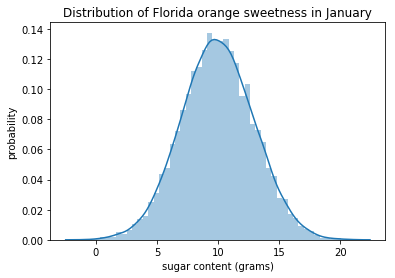

In [18]:
jan_dist = tfd.Normal(loc=10., scale=3.)

jan_samples = jan_dist.sample(10000).numpy()
ax = sns.distplot(jan_samples)
ax.set(
    xlabel="sugar content (grams)", 
    ylabel="probability",
    title="Distribution of Florida orange sweetness in January"
)

Multivariate Gaussians represent multiple Gaussians with a mean and **covariance**.

Notice it's no longer just variance, but **covariance** which measures the relationship between two Gaussians.

Each observation, becomes the joint realization of two Gaussian distributions - the sweetness of navel orange in December and the sweetness of a navel orange in January.

So now,

$\begin{bmatrix} X_{december} \\ X_{january} \end{bmatrix}$ ~ $N(\begin{bmatrix} \mu_{december} \\ \mu_{january} \end{bmatrix}, \sum)$

Where the univariate Gaussian Normal distribution had a probability density function of

${f(x\mid \mu ,\sigma ^{2})={\frac {1}{\sqrt {2\pi \sigma ^{2}}}}e^{-{\frac {(x-\mu )^{2}}{2\sigma ^{2}}}}}$

The multivariate Gaussian becomes:

${f(x\mid \mu ,\sum)={\frac {1}{\sqrt {2\pi^{n} \mid\sum\mid}}}e^{-{\frac {(x-\mu )^{2}}{2\sum}}}}$

Let's plot the two Gaussians!

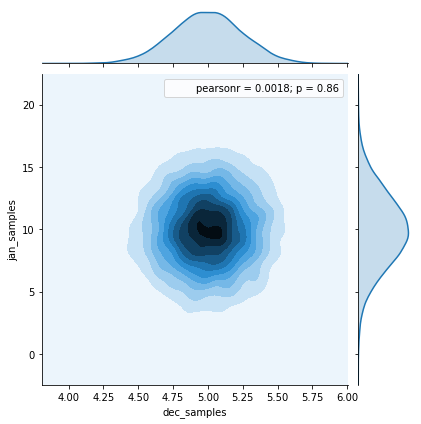

In [19]:
data_dict = {
    "dec_samples": dec_samples,
    "jan_samples": jan_samples
}

data_df = pd.DataFrame.from_dict(data_dict)

sns.jointplot(
    x="dec_samples", 
    y="jan_samples", 
    data=data_df, 
    kind="kde", 
#     xlim=(0, 20),
#     ylim=(0, 20)
)

Let's extend the multivariate case to more dimensions. We'll draw more samples of navel orange sugar content from different months of the year.

For February, March and April.

In [124]:
feb_dist = tfd.Normal(loc=15., scale=3.)
mar_dist = tfd.Normal(loc=20., scale=1.)
apr_dist = tfd.Normal(loc=25., scale=1.)

Let's build a helper function to sample and plot the data.

In [125]:
def sample_from_all_months(num_to_sample):
    """
    Given num_to_sample, samples from all predefined distributions
    and returns array of arrays of sampled values.
    """
    return [
        dec_dist.sample(num_to_sample).numpy(),
        jan_dist.sample(num_to_sample).numpy(),
        feb_dist.sample(num_to_sample).numpy(),
        mar_dist.sample(num_to_sample).numpy(),
        apr_dist.sample(num_to_sample).numpy()
    ]

In [126]:
from scipy.interpolate import interp1d

def plot_sampled_data(num_to_sample=10):
    """
    Plots the data in dataframe.
    """

    df = pd.DataFrame.from_records(sample_from_all_months(num_to_sample))
    df.index = ['dec 2017', 'jan 2018', 'feb 2018', 'mar 2018', 'apr 2018']

    fig, ax = plt.subplots()
    
    # curve fitting per observation
    x_new = np.linspace(0, 4, 500)
    for obs in df.columns:
        f = interp1d(np.arange(0, 5), df[obs].values, kind='quadratic')
        y_smooth = f(x_new)
        ax.plot(x_new, y_smooth)
    
    # plot actual data
    sns.swarmplot(data=df.T, ax=ax)
    ax.set(
        title='Florida orange sweetness', 
        xlabel='date', 
        ylabel='sugar content',
        ylim=(0, 30)
    )
    
    return df

### Gaussian Process

Gaussian processes are a generalization of multivariate Gaussian distribution to infinitely many variables.

Formal definition:

```
A Gaussian process is a collection of random variables, any finite number of which have (consistent) Gaussian distributions.
```

Defined by two things: 

* mean function, $m(x)$ 
* covariance function $K(x, x')$ (always positive definite)


$f(x)$ ~ $GP(m(x), K(x, x'))$ 

I believe that $x$ and $x'$ are essentially the same, a long vector representation of all of the input space.

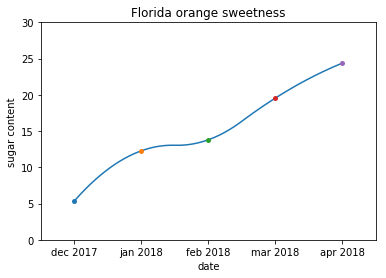

In [127]:
one_sample = plot_sampled_data(1)

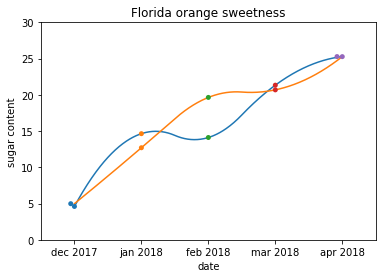

In [128]:
two_sample = plot_sampled_data(2)

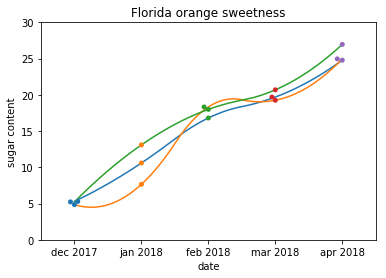

In [129]:
three_sample = plot_sampled_data(3)

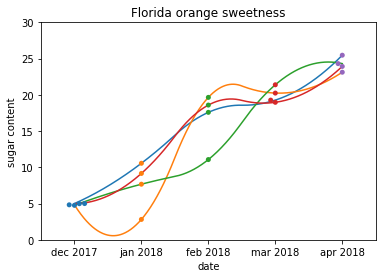

In [130]:
four_sample = plot_sampled_data(4)

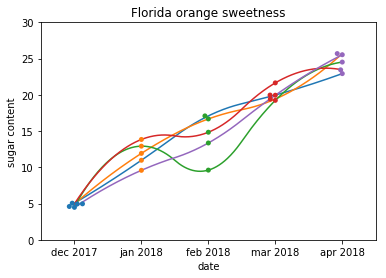

In [131]:
five_sample = plot_sampled_data(5)

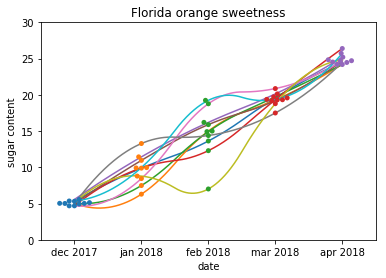

In [132]:
ten_sample = plot_sampled_data(10)

In [212]:
import GPy

NUM_MONTHS = 5
NUM_OBS_PER_MONTH = 10

x = np.array([1, 2, 3, 4, 5])
data = np.asarray(sample_from_all_months(10))

new_x = np.tile(x, (NUM_OBS_PER_MONTH, 1)).T
new_x = np.resize(new_x, (NUM_OBS_PER_MONTH * NUM_MONTHS, 1))

new_y = np.resize(data, (NUM_OBS_PER_MONTH * NUM_MONTHS, 1))

In [219]:
kernel = GPy.kern.RBF(1, 1., lengthscale=10.)
gp = GPy.models.GPRegression(new_x, new_y, kernel)
gp.optimize_restarts(num_restarts=7)

Optimization restart 1/7, f = 128.00926840433914
Optimization restart 2/7, f = 128.0092684022114
Optimization restart 3/7, f = 128.00926840162734
Optimization restart 4/7, f = 128.0092684017536
Optimization restart 5/7, f = 128.0092684017407
Optimization restart 6/7, f = 128.00926840137214
Optimization restart 7/7, f = 128.00926842420972


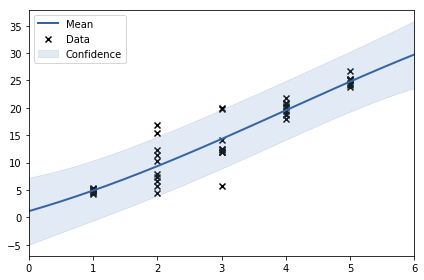

In [220]:
gp.plot()

### GP Regression

Recall that Gaussian process defined by two things: 

* mean function, $m(x)$ 
* covariance function $K(x, x')$


$f(x)$ ~ $GP(m(x), K(x, x'))$


**Non-linear regression (parametric)**

Estimate the output `y(x)` with some function plus some Gaussian noise.

$y(x) = f(x) + \epsilon\sigma_y$

$p(\epsilon) = N(0, 1)$

In [80]:
def gaussian_noise(x):
    """ 
    Adds some Gaussian noise to an input
    
    y = x + noise
    """
    return x + np.random.normal(0, 1)

x = np.linspace(-10, 10, 100)
y = [gaussian_noise(i) for i in x]

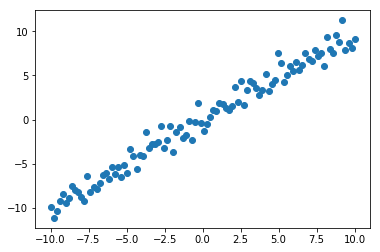

In [82]:
plt.scatter(x, y)
# plt.xlim(-10, 10)
# plt.ylim(-5, 5)

# Imagine a straight line y = x going through the middle, 
# and the rest being noise

Place a GP prior over non-linear function.

$p(f(x)|\theta) = GP(0, K(x, x'))$

and covariance is: $K(x, x') = \sigma^2 exp(-\frac{1}{2l^2}(x-x')^2)$

The covariance "kernel" is something you can tune as well.

The $l$ (length-scale - how wide to wiggle) and $\sigma$ (how tall to wiggle) are hyperparameters that can be tuned.

Because we assume that noise is Gaussian and because sum of Gaussians is also Gaussian - doing this induces a GP over $y(x)$, for regression purposes. And then can use something like maximum a posteriori to find the $\theta$.

$p(y(x)|\theta) = GP(0, K(x, x') + I\sigma^2_y)$

### Conclusion

* Built an intuition for Gaussians (univariate and multivariate)
* Observed how a Gaussian process inherently captures uncertainty in measurements
* Briefly touched the tip of the iceberg for GP regression

### Thanks!

### References

- Rasmussen & Williams - "Gaussian Processes for Machine Learning"
- Nando de Freitas - "Machine learning - Introduction to Gaussian processes": https://www.youtube.com/watch?reload=9&v=4vGiHC35j9s&t=2184s
- J. Cunningham - "Gaussian Processes for Machine Learning" @ MLSS 2012